# Projeto: Classificação de redes complexas - Redes Complexas (SME0130)
---

Aluno: Rafael Fernando Gigante

N° USP: 12610500

#Bibliotecas utilizadas#

In [40]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Implementação das medidas e resultados#

In [41]:
def momento_de_grau_m(G,m):
    momento = 0
    N = len(G)
    for i in G.nodes:
        momento += G.degree(i)**m
    momento = momento/N
    return momento

In [42]:
def calcular_medidas(G):
    medidas = []

    # Número de vértices e arestas da rede
    N = len(G)
    M = G.number_of_edges()

    # Primeiro momento
    k1 = momento_de_grau_m(G,1)
    medidas.append(k1)

    # Segundo momento
    k2 = momento_de_grau_m(G,2)
    medidas.append(k2)

    # Variância
    variance = momento_de_grau_m(G,2) - momento_de_grau_m(G,1)**2
    medidas.append(variance)

    # Average clustering
    av_cl = nx.average_clustering(G)
    medidas.append(av_cl)

    # Average shortest path lenght
    l = nx.average_shortest_path_length(G)
    medidas.append(l)

    # Degree assortativity coefficient
    r=nx.degree_assortativity_coefficient(G)
    medidas.append(r)

    return medidas

In [43]:
cl = ['ER','WS','BA']

def gerar_redes(N, k1, n_nets):
    X = []
    y = []
    av_degree = k1

    # ER networks
    p = av_degree/(N-1)
    for i in range(0,n_nets):
        GER = nx.gnp_random_graph(N, p, seed=None, directed=False)
        Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
        GER = GER.subgraph(Gcc[0])
        GER = nx.convert_node_labels_to_integers(GER, first_label=0)
        medidas = calcular_medidas(GER)
        X.append(medidas)
        y.append(0.0)

    # WS networks
    k = int(av_degree)
    p = 0.1 #probability of rewiring
    for i in range(0,n_nets):
        GWS = nx.watts_strogatz_graph(N, k, p, seed=None)
        Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
        GWS = GWS.subgraph(Gcc[0])
        GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
        medidas = calcular_medidas(GWS)
        X.append(medidas)
        y.append(1.0)

    # BA networks
    m = int(av_degree/2)
    for i in range(0,n_nets):
        GBA = nx.barabasi_albert_graph(N, m)
        Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
        GBA = GBA.subgraph(Gcc[0])
        GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
        medidas = calcular_medidas(GBA)
        X.append(medidas)
        y.append(2.0)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [44]:
def abrir_rede(caminho):
    G = nx.read_edgelist(caminho, nodetype=int, data=(('weight',float),))
    G = G.to_undirected()
    G.remove_edges_from(nx.selfloop_edges(G))
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    N = len(G)
    M = G.number_of_edges()
    print('Number of nodes:', N)
    print('Number of edges:', M)

    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color="b", node_size=50, with_labels=False)

    return G, N, M

In [45]:
def data_panda(x,y):
    data = pd.DataFrame(x)
    d_y = pd.DataFrame(y)
    return data

In [46]:
def data_pca(data):
    # Instanciar objeto PCA
    pca = PCA(n_components=2)

    # Aplicar PCA ao DataFrame
    data_PCA = pca.fit_transform(data)

    # Converter os resultados para um novo DataFrame
    data_PCA = pd.DataFrame(data_PCA)

    # Exibir o DataFrame transformado
    return data_PCA

In [47]:
def grafico_pca(data_PCA,y):
    # Separar os dados em colunas
    eixo_x = data_PCA[0]
    eixo_y = data_PCA[1]
    colors = y

    plt.title("PCA", fontsize = 22)
    # Definir rótulos dos eixos
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    colors = y

    # Mapear os valores numéricos para cores
    color_map = {0.0: 'blue', 1.0: 'green', 2.0: 'orange'}
    color_labels = [color_map[val] for val in colors]

    # Criar o gráfico de dispersão
    plt.scatter(eixo_x, eixo_y, c=color_labels)

    # Criar a legenda das cores
    unique_values = np.unique(colors)
    label=['ER', 'WS', 'BA']
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[val], label=label[int(val)]) for val in unique_values]
    plt.legend(handles=legend_elements)

    # Exibir o gráfico
    plt.show()

# Classificação das redes #

## Network Science ##

This is a network of co-authorships in the area of network science.

Number of nodes: 379
Number of edges: 914


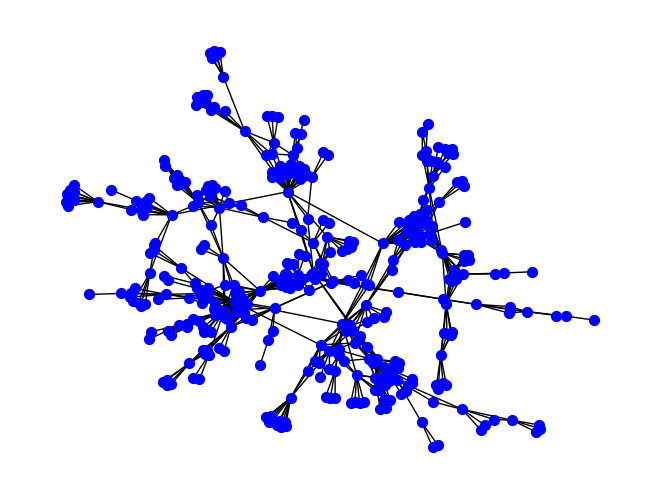

In [48]:
G, N, M = abrir_rede("/out.netscience")

In [49]:
medidas = calcular_medidas(G)
X_net = medidas
print(X_net)

[4.823218997361478, 38.68601583113456, 15.422574334625903, 0.7412306142925664, 6.041867347935949, -0.08167784834672825]


In [50]:
X, y = gerar_redes(N, X_net[0],30)

In [51]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1,len(X_net))
X_net = scaler.transform(X_net)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

KNeighborsClassifier(metric='euclidean')

In [52]:
y_pred = model.predict(X_net)
print(y_pred)
print('Classe:', cl[int(y_pred)])

[1.]
Classe: WS


<ipython-input-52-5b4245e72690>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Classe:', cl[int(y_pred)])


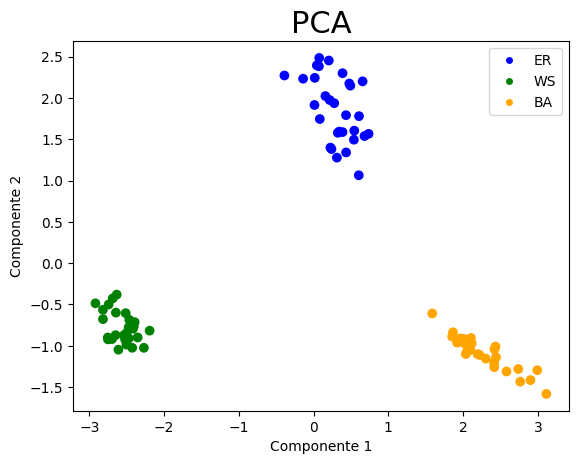

In [53]:
data = data_panda(X,y)
data_PCA = data_pca(data)
grafico_pca(data_PCA,y)

In [54]:
data = []
data.append(['Network Science'] + [N, M]  + medidas)
data[0].append(cl[int(y_pred)])
df = pd.DataFrame(data, columns=['Network', 'N', 'M', '<k>', '<k²>', 'var', 'c', 'l', 'r', 'classe'])
df.head()

<ipython-input-54-a007e7d55ed2>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[0].append(cl[int(y_pred)])


,Network,N,M,<k>,<k²>,var,c,l,r,classe
0,Network Science,379,914,4.823219,38.686016,15.422574,0.741231,6.041867,-0.081678,WS


## Jazz musicians ##

This is the collaboration network between Jazz musicians. Each node is a Jazz musician and an edge denotes that two musicians have played together in a band. The data was collected in 2003.

Number of nodes: 198
Number of edges: 2742


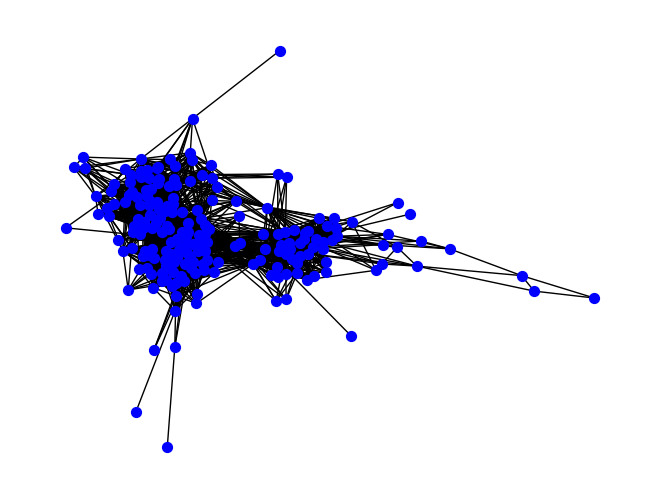

In [111]:
G, N, M = abrir_rede("/out.jazz")

In [112]:
medidas = calcular_medidas(G)
X_net = medidas
print(X_net)

[27.696969696969695, 1070.2424242424242, 303.1202938475667, 0.6174507021536301, 2.2350407629595446, 0.020237399275047713]


In [113]:
X, y = gerar_redes(N, X_net[0],30)

In [114]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1,len(X_net))
X_net = scaler.transform(X_net)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

KNeighborsClassifier(metric='euclidean')

In [115]:
y_pred = model.predict(X_net)
print(y_pred)
print('Classe:', cl[int(y_pred)])

[0.]
Classe: ER


<ipython-input-115-5b4245e72690>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Classe:', cl[int(y_pred)])


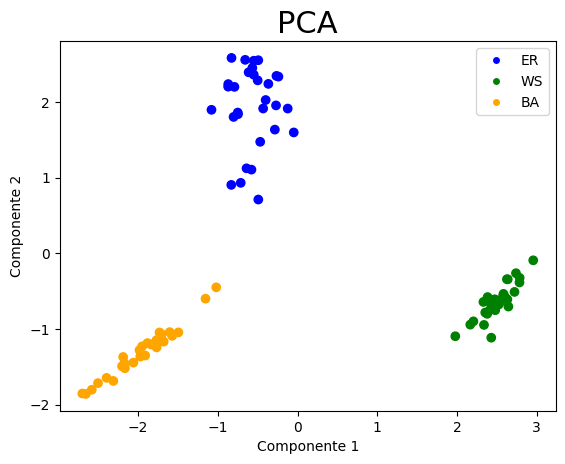

In [116]:
data = data_panda(X,y)
data_PCA = data_pca(data)
grafico_pca(data_PCA,y)

In [61]:
data = []
data.append(['Jazz musicians'] + [N, M]  + medidas)
data[0].append(cl[int(y_pred)])
df = pd.DataFrame(data, columns=['Network', 'N', 'M', '<k>', '<k²>', 'var', 'c', 'l', 'r', 'classe'])
df.head()

<ipython-input-61-ac0bcdd564b2>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[0].append(cl[int(y_pred)])


,Network,N,M,<k>,<k²>,var,c,l,r,classe
0,Jazz musicians,198,2742,27.69697,1070.242424,303.120294,0.617451,2.235041,0.020237,ER


## Physicians ##

This directed network captures innovation spread among 246 physicians in for towns in Illinois, Peoria, Bloomington, Quincy and Galesburg. The data was collected in 1966. A node represents a physician and an edge between two physicians shows that the left physician told that the righ physician is his friend or that he turns to the right physician if he needs advice or is interested in a discussion. There always only exists one edge between two nodes even if more than one of the listed conditions are true.

Number of nodes: 453
Number of edges: 2025


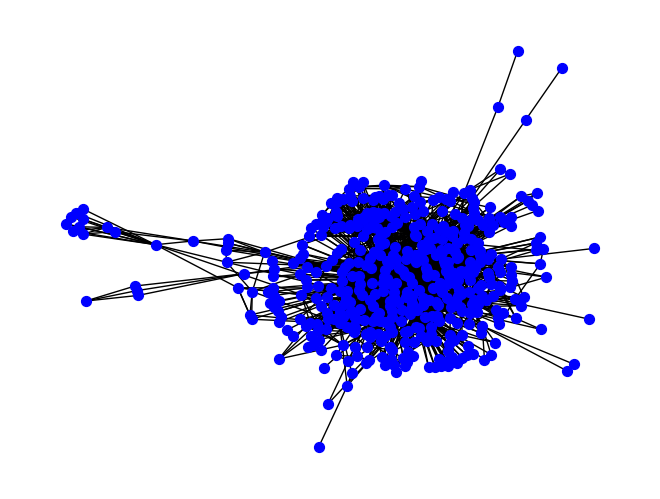

In [164]:
G, N, M = abrir_rede("/out.physicians")

In [165]:
medidas = calcular_medidas(G)
X_net = medidas
print(X_net)

[8.940397350993377, 358.49006622516555, 278.55936143151615, 0.6464630921565053, 2.6637851882240327, -0.22582088796832953]


In [166]:
X, y = gerar_redes(N, X_net[0],30)

In [167]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1,len(X_net))
X_net = scaler.transform(X_net)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

KNeighborsClassifier(metric='euclidean')

In [168]:
y_pred = model.predict(X_net)
print(y_pred)
print('Classe:', cl[int(y_pred)])

[2.]
Classe: BA


<ipython-input-168-5b4245e72690>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Classe:', cl[int(y_pred)])


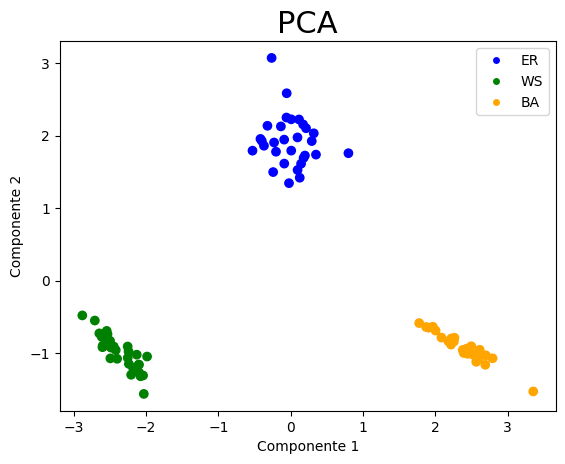

In [169]:
data = data_panda(X,y)
data_PCA = data_pca(data)
grafico_pca(data_PCA,y)

In [170]:
data = []
data.append(['Physicians'] + [N, M]  + medidas)
data[0].append(cl[int(y_pred)])
df = pd.DataFrame(data, columns=['Network', 'N', 'M', '<k>', '<k²>', 'var', 'c', 'l', 'r', 'classe'])
df.head()

<ipython-input-170-78d3ef641be7>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[0].append(cl[int(y_pred)])


,Network,N,M,<k>,<k²>,var,c,l,r,classe
0,Physicians,453,2025,8.940397,358.490066,278.559361,0.646463,2.663785,-0.225821,BA


## Caenorhabditis elegans ##
This is the metabolic network of the roundworm Caenorhabditis elegans. Nodes are metabolites (e.g., proteins), and edges are interactions between them. Since a metabolite can iteract with itself, the network contains loops. The interactions are undirected. There may be multiple interactions between any two metabolites.

Number of nodes: 117
Number of edges: 465


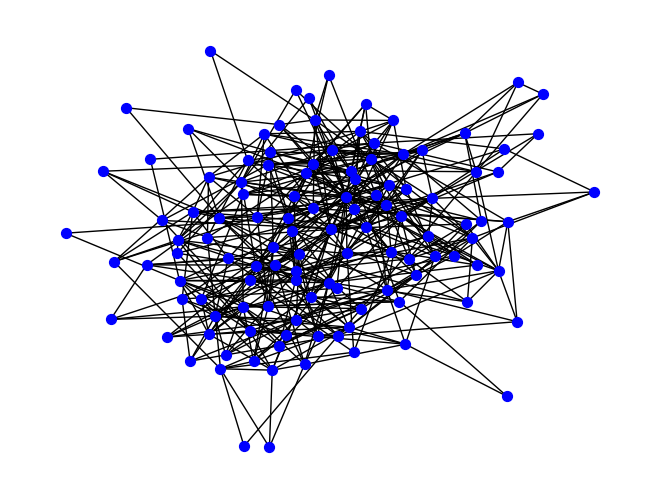

In [159]:
G, N, M = abrir_rede("/out.elegans")

In [160]:
medidas = calcular_medidas(G)
X_net = medidas
print(X_net)

[7.948717948717949, 79.16239316239316, 15.980276134122278, 0.21923205948846972, 2.5870910698496905, -0.08415842551291443]


In [161]:
X, y = gerar_redes(N, X_net[0],30)

In [162]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1,len(X_net))
X_net = scaler.transform(X_net)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

KNeighborsClassifier(metric='euclidean')

In [163]:
y_pred = model.predict(X_net)
print(y_pred)
print('Classe:', cl[int(y_pred)])

[0.]
Classe: ER


<ipython-input-163-ebbbd04cb64d>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Classe:', cl[int(y_pred)])


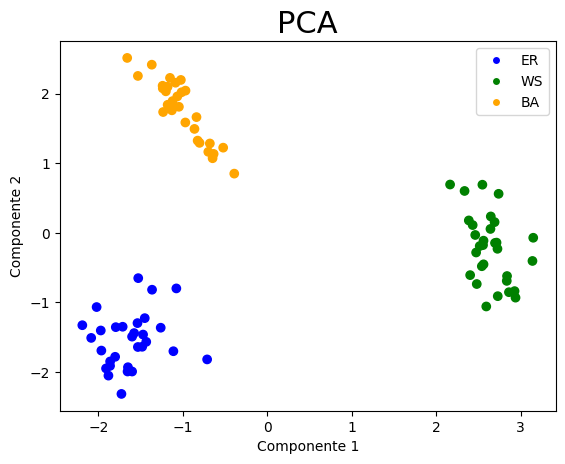

In [148]:
data = data_panda(X,y)
data_PCA = data_pca(data)
grafico_pca(data_PCA,y)

In [75]:
data = []
data.append(['Caenorhabditis elegans'] + [N, M]  + medidas)
data[0].append(cl[int(y_pred)])
df = pd.DataFrame(data, columns=['Network', 'N', 'M', '<k>', '<k²>', 'var', 'c', 'l', 'r', 'classe'])
df.head()

<ipython-input-75-bf95173abd6d>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[0].append(cl[int(y_pred)])


,Network,N,M,<k>,<k²>,var,c,l,r,classe
0,Caenorhabditis elegans,117,465,7.948718,79.162393,15.980276,0.219232,2.587091,-0.084158,ER


## PDZBase ##
This is a network of protein–protein interactions from PDZBase.

Number of nodes: 161
Number of edges: 209


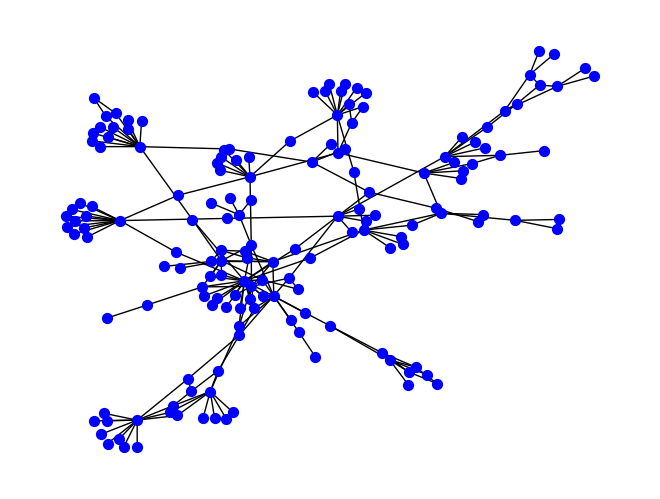

In [76]:
G, N, M = abrir_rede("/out.pdzbase")

In [77]:
medidas = calcular_medidas(G)
X_net = medidas
print(X_net)

[2.5962732919254656, 15.254658385093167, 8.514023378727673, 0.007004830917874396, 5.326086956521739, -0.46585318485085137]


In [78]:
X, y = gerar_redes(N, X_net[0],30)

In [79]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1,len(X_net))
X_net = scaler.transform(X_net)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

KNeighborsClassifier(metric='euclidean')

In [80]:
y_pred = model.predict(X_net)
print(y_pred)
print('Classe:', cl[int(y_pred)])

[2.]
Classe: BA


<ipython-input-80-ebbbd04cb64d>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Classe:', cl[int(y_pred)])


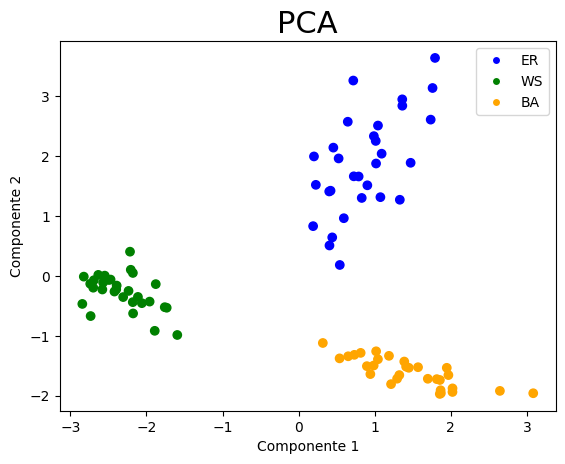

In [81]:
data = data_panda(X,y)
data_PCA = data_pca(data)
grafico_pca(data_PCA,y)

In [82]:
data = []
data.append(['PDZBase'] + [N, M]  + medidas)
data[0].append(cl[int(y_pred)])
df = pd.DataFrame(data, columns=['Network', 'N', 'M', '<k>', '<k²>', 'var', 'c', 'l', 'r', 'classe'])
df.head()

<ipython-input-82-4ceff8258264>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[0].append(cl[int(y_pred)])


,Network,N,M,<k>,<k²>,var,c,l,r,classe
0,PDZBase,161,209,2.596273,15.254658,8.514023,0.007005,5.326087,-0.465853,BA


## Human proteins (Stelzl) ##
This network represens interacting pairs of protein in Humans (Homo sapiens).

Number of nodes: 1615
Number of edges: 3106


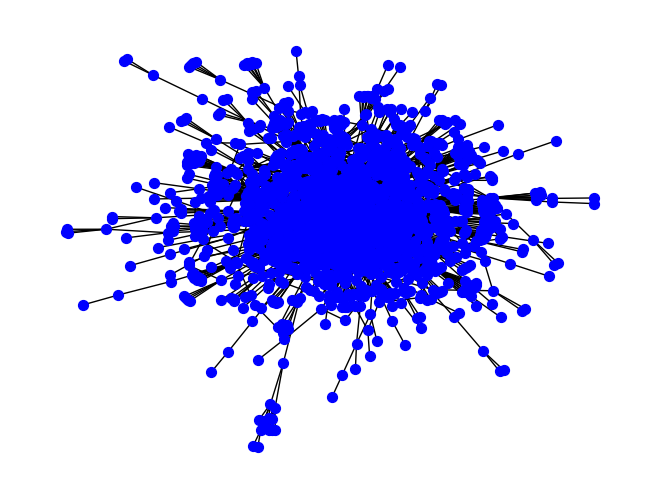

In [83]:
G, N, M = abrir_rede("/out.Stelzl")

In [84]:
medidas = calcular_medidas(G)
X_net = medidas
print(X_net)

[3.846439628482972, 65.64829721362229, 50.85319939805806, 0.006273664470975432, 4.84803173470523, -0.20204015265266073]


In [85]:
X, y = gerar_redes(N, X_net[0],30)

In [86]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1,len(X_net))
X_net = scaler.transform(X_net)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

KNeighborsClassifier(metric='euclidean')

In [87]:
y_pred = model.predict(X_net)
print(y_pred)
print('Classe:', cl[int(y_pred)])

[2.]
Classe: BA


<ipython-input-87-ebbbd04cb64d>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Classe:', cl[int(y_pred)])


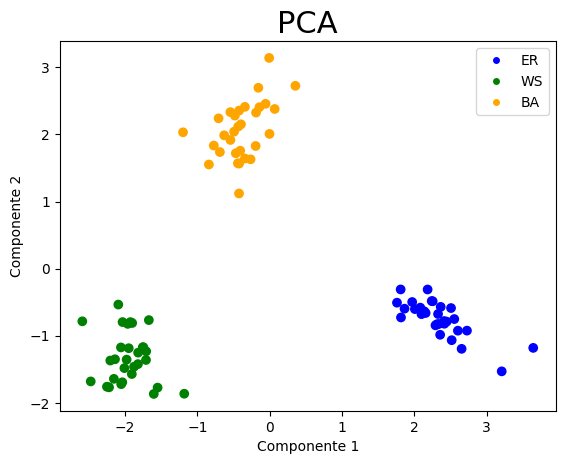

In [88]:
data = data_panda(X,y)
data_PCA = data_pca(data)
grafico_pca(data_PCA,y)

In [89]:
data = []
data.append(['Human proteins '] + [N, M]  + medidas)
data[0].append(cl[int(y_pred)])
df = pd.DataFrame(data, columns=['Network', 'N', 'M', '<k>', '<k²>', 'var', 'c', 'l', 'r', 'classe'])
df.head()

<ipython-input-89-aa5fbeb8d550>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[0].append(cl[int(y_pred)])


,Network,N,M,<k>,<k²>,var,c,l,r,classe
0,Human proteins,1615,3106,3.84644,65.648297,50.853199,0.006274,4.848032,-0.20204,BA


## Power grid ##

This undirected network contains information about the power grid of the Western States of the United States of America. An edge represents a power supply line. A node is either a generator, a transformator or a substation.

Number of nodes: 4941
Number of edges: 6594


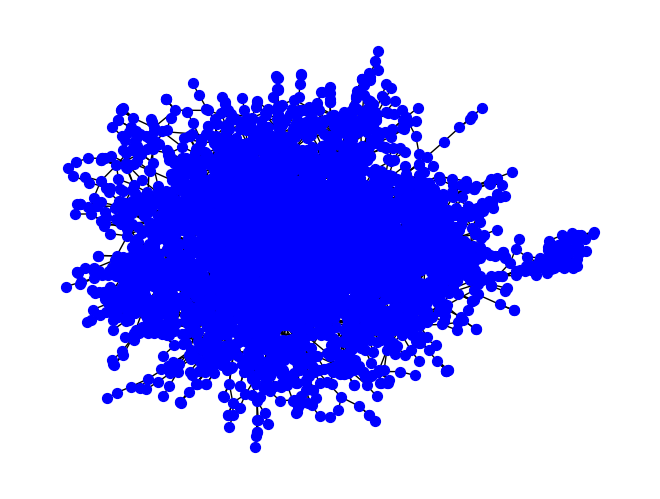

In [90]:
G, N, M = abrir_rede("/out.powergrid.opsahl-powergrid")

In [91]:
medidas = calcular_medidas(G)
X_net = medidas
print(X_net)

[2.66909532483303, 10.332726168791742, 3.2086563157462056, 0.08010361108159712, 18.989185424445708, 0.0034569877442048825]


In [92]:
X, y = gerar_redes(N, X_net[0],30)

In [93]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1,len(X_net))
X_net = scaler.transform(X_net)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

KNeighborsClassifier(metric='euclidean')

In [94]:
y_pred = model.predict(X_net)
print(y_pred)
print('Classe:', cl[int(y_pred)])

[0.]
Classe: ER


<ipython-input-94-ebbbd04cb64d>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Classe:', cl[int(y_pred)])


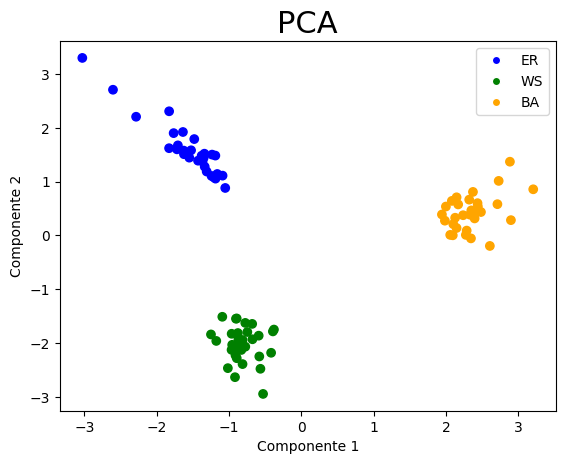

In [95]:
data = data_panda(X,y)
data_PCA = data_pca(data)
grafico_pca(data_PCA,y)

In [96]:
data = []
data.append(['Power grid'] + [N, M]  + medidas)
data[0].append(cl[int(y_pred)])
df = pd.DataFrame(data, columns=['Network', 'N', 'M', '<k>', '<k²>', 'var', 'c', 'l', 'r', 'classe'])
df.head()

<ipython-input-96-c5029d006ff7>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[0].append(cl[int(y_pred)])


,Network,N,M,<k>,<k²>,var,c,l,r,classe
0,Power grid,4941,6594,2.669095,10.332726,3.208656,0.080104,18.989185,0.003457,ER


## US airports ##
This is the directed network of flights between US airports in 2010. Each edge represents a connection from one airport to another, and the weight of an edge shows the number of flights on that connection in the given direction, in 2010.

Number of nodes: 1572
Number of edges: 17214


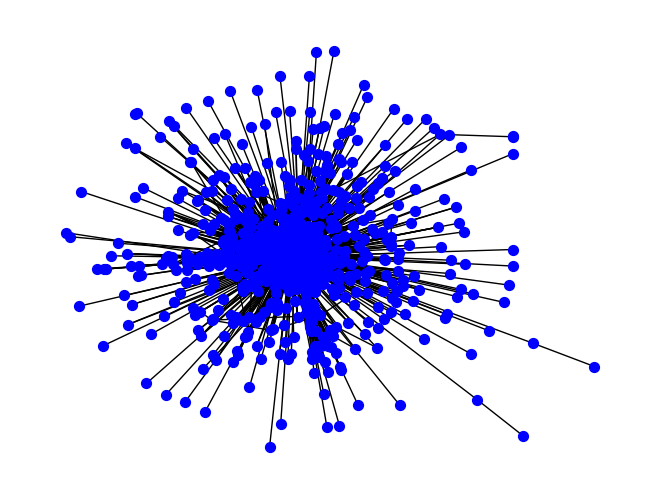

In [97]:
G, N, M = abrir_rede("/out.usairport")

In [98]:
medidas = calcular_medidas(G)
X_net = medidas
print(X_net)

[21.900763358778626, 2457.8944020356234, 1978.250966338403, 0.5047939546538639, 3.1151638395019137, -0.11340155515827577]


In [99]:
X, y = gerar_redes(N, X_net[0],30)

In [100]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1,len(X_net))
X_net = scaler.transform(X_net)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

KNeighborsClassifier(metric='euclidean')

In [101]:
y_pred = model.predict(X_net)
print(y_pred)
print('Classe:', cl[int(y_pred)])

[2.]
Classe: BA


<ipython-input-101-ebbbd04cb64d>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Classe:', cl[int(y_pred)])


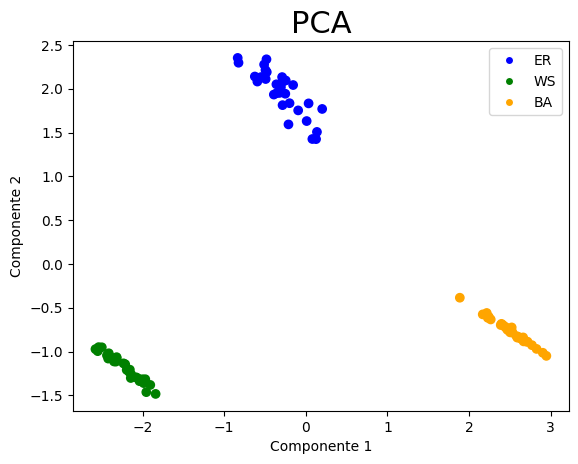

In [102]:
data = data_panda(X,y)
data_PCA = data_pca(data)
grafico_pca(data_PCA,y)

In [103]:
data = []
data.append(['US airports'] + [N, M]  + medidas)
data[0].append(cl[int(y_pred)])
df = pd.DataFrame(data, columns=['Network', 'N', 'M', '<k>', '<k²>', 'var', 'c', 'l', 'r', 'classe'])
df.head()

<ipython-input-103-ceddb974ce51>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[0].append(cl[int(y_pred)])


,Network,N,M,<k>,<k²>,var,c,l,r,classe
0,US airports,1572,17214,21.900763,2457.894402,1978.250966,0.504794,3.115164,-0.113402,BA


## Euroroads ##
This is the international E-road network, a road network located mostly in Europe. The network is undirected; nodes represent cities and an edge between two nodes denotes that they are connected by an E-road.

Number of nodes: 1039
Number of edges: 1305


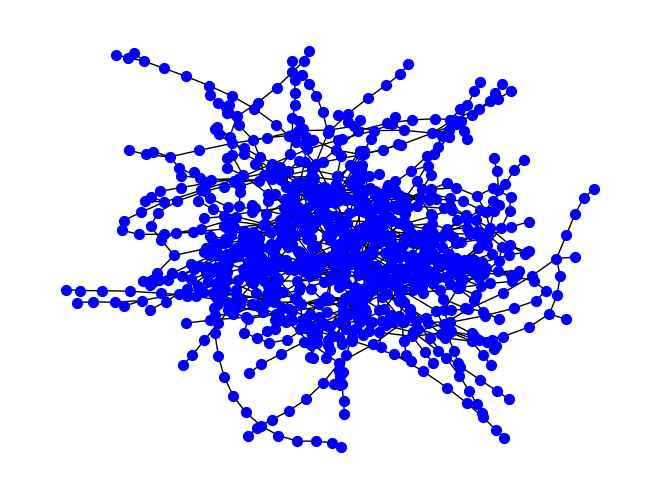

In [104]:
G, N, M = abrir_rede("/out.euroroads.subelj_euroroad_euroroad")

In [105]:
medidas = calcular_medidas(G)
X_net = medidas
print(X_net)

[2.512030798845043, 7.753609239653513, 1.4433105053074469, 0.018905541042210917, 18.39514614059391, 0.09003981380055513]


In [106]:
X, y = gerar_redes(N, X_net[0],30)

In [107]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1,len(X_net))
X_net = scaler.transform(X_net)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

KNeighborsClassifier(metric='euclidean')

In [108]:
y_pred = model.predict(X_net)
print(y_pred)
print('Classe:', cl[int(y_pred)])

[0.]
Classe: ER


<ipython-input-108-ebbbd04cb64d>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Classe:', cl[int(y_pred)])


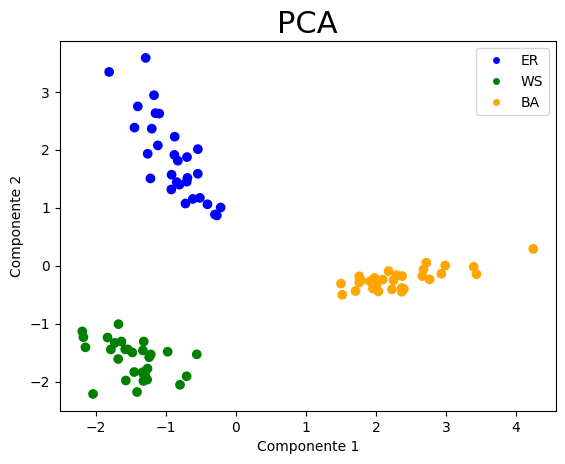

In [109]:
data = data_panda(X,y)
data_PCA = data_pca(data)
grafico_pca(data_PCA,y)

In [110]:
data = []
data.append(['Euroroads'] + [N, M]  + medidas)
data[0].append(cl[int(y_pred)])
df = pd.DataFrame(data, columns=['Network', 'N', 'M', '<k>', '<k²>', 'var', 'c', 'l', 'r', 'classe'])
df.head()

<ipython-input-110-5b17ebfb2c66>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[0].append(cl[int(y_pred)])


,Network,N,M,<k>,<k²>,var,c,l,r,classe
0,Euroroads,1039,1305,2.512031,7.753609,1.443311,0.018906,18.395146,0.09004,ER


# Conclusões #

## Resultados obtidos ##

Tabela contendo os resultados obtidos para as redes utilizadas:

|         Network        |   N  |   M   | \<k> | <k²> |     var     |     c    |     l     |     r     | Class |
|:----------------------:|:----:|:-----:|:------------:|:------------------:|:-----------:|:--------:|:---------:|:---------:|:-----:|
|        Network Science |  379 |   914 |     4.823219 |          38.686016 |   15.422574 | 0.741231 |  6.041867 | -0.081678 |    WS |
|         Jazz musicians |  198 |  2742 |     27.69697 |        1070.242424 |  303.120294 | 0.617451 |  2.235041 |  0.020237 |    ER |
|             Physicians |  117 |   465 |     7.948718 |          79.162393 |   15.980276 | 0.219232 |  2.587091 | -0.084158 |    BA |
| Caenorhabditis elegans |  453 |  2025 |     8.940397 |         358.490066 |  278.559361 | 0.646463 |  2.663785 | -0.225821 |    ER |
|                PDZBase |  161 |   209 |     2.596273 |          15.254658 |    8.514023 | 0.007005 |  5.326087 | -0.465853 |    BA |
|         Human proteins | 1615 |  3106 |      3.84644 |          65.648297 |   50.853199 | 0.006274 |  4.848032 |  -0.20204 |    BA |
|             Power grid | 4941 |  6594 |     2.669095 |          10.332726 |    3.208656 | 0.080104 | 18.989185 |  0.003457 |    ER |
|            US airports | 1572 | 17214 |    21.900763 |        2457.894402 | 1978.250966 | 0.504794 |  3.115164 | -0.113402 |    BA |
|              Euroroads | 1039 |  1305 |     2.512031 |           7.753609 |    1.443311 | 0.018906 | 18.395146 |   0.09004 |    ER |

A escolha do modelo mais adequado para descrever uma rede biológica, tecnológica ou social depende das características específicas de cada tipo de rede. A seguir, feita uma breve descrição de cada um dos modelos:

1. Modelo de Érdos-Renyi (ER)
  -  Neste modelo, cada par de nós tem uma probabilidade fixa 𝑝 de estarem conectados. O resultado é uma rede aleatória.

2. Modelo de Albert-Barabasi (AB)
  -  Este modelo gera redes com uma distribuição de grau de potência , onde poucos nós têm muitas conexões e muitos nós têm poucas conexões, formando redes sem escala.

3. Modelo de Watts-Strogatz (WS)
  - Este modelo gera redes com características de "pequeno mundo", caracterizadas por alta eficiência na transmissão de informação (curta distância média entre os nós) e alta clustering (tendência de formar triângulos).

Para redes sociais, geralmente são exibidas propriedades de "pequeno mundo" e a presença de hubs. Desse modo, os modelos de Albert-Barabasi e de Watts-Strogatz seriam os mais adequados para descrevê-las. No projeto foi utilizada uma rede de co-autoria e outras duas de interação humana no mundo real. Cada uma das redes foi classificada como um dos modelos.

Para redes biológicas, o modelo de Albert-Barabasi é o mais adequado, principalmente quando se trata de genes ou proteínas. Essas redes possuíem como característica dominante sua distribuição de grau sem escala e a presença de hubs. No projeto, duas das redes utilizadas foram classificadas como Albert=Barabasi e a outra foi classificada como Érdos-Renyi.

Para as redes tecnológicas foram utilizadas três redes de infraesturura, ou seja, elas possuem limitações físicas nas suas conexões. Para a rede de aeroportos é esperado uma distribuição de grau em lei de potência, com poucos aeroportos principais conectados a muitos aeroportos menores. O modelo mais adequado para classificar essa rede é o de Albert-Barabasi, concordando com a classificação obtida no projeto. As outras duas redes, power grid e euroroads, foram classificadas como Érdos-Renyi.

Desse modo, concluímos que não necessariamente todas as redes de uma mesma categoria serão classificadas como sendo do mesmo modelo. É importante considerar as peculiaridades de cada rede individualmente, assim podemos verificar qual modelo é o mais adequado para descrevê-la.


## Medidas comuns para cada um dos modelos ##

1. Modelo de Érdos-Renyi (ER)
  - Distribuição de grau: segue uma distribuição de Poisson.
  - Comprimento médio do caminho: tendem a ter um comprimento médio do caminho que cresce logaritmicamente com o número de nós.
  - Coeficiente de clustering: o coeficiente de clustering é baixo e aproximadamente igual à probabilidade de uma ligação entre quaisquer dois nós, p.
  - Distribuição de componentes conexas: a distribuição dos tamanhos dos componentes conexas pode ser usada para identificar o ponto de transição de percolação, onde uma componente gigante surge.

2. Modelo de Albert-Barabasi (AB)
  - Distribuição de grau: segue uma distribuição de grau em lei de potência.
  - Comprimento médio do caminho: similar ao modelo ER, mas redes AB frequentemente têm um comprimento médio do caminho menor devido à presença de hubs.
  - Coeficiente de clustering: pode variar, mas redes AB geralmente exibem um coeficiente de clustering maior do que redes ER.
  - Assortatividade: redes AB geralmente são desassortativas.

3. Modelo de Watts-Strogatz (WS)
  - Distribuição de grau: inicialmente, é semelhante à de uma rede regular, mas após a reconfiguração de ligações, a distribuição de grau pode variar dependendo do número de ligações reconfiguradas.
  - Comprimento médio do caminho: redes WS têm um comprimento médio do caminho pequeno, similar às redes ER, mas com um coeficiente de clustering significativamente maior.
  - Coeficiente de clustering: muito mais alto do que em redes ER.